<br>

<center>
    <span style="font-size:24px; font-weight:bold;">Vehicle Tracker & Counter - Object Detection + YOLOv8 + Custom BBox</span>
</center>

<hr style="border: none; border-top: 1px solid #000;">

<center>
    <span>
        Created by <b>Ian Yap</b>
        <!-- Data from <a href="https://www"><b>Kaggle</b></a> -->
    </span>
</center>

<br>

<center>
    <span>
        <a href="https://www.linkedin.com/in/ian-yap-052870139/"><b>LinkedIn</b></a>
        &emsp;|&emsp;
        <a href="https://xiyap.github.io/"><b>Portfolio</b></a>
    </span>
</center>
    
<hr style="border: none; border-top: 1px solid #000;">


## Objectives

The objective of this project is to **develop an object detection model to track and count vehicles in individual lanes while selectively disregarding less significant vehicles.**

## Install Dependencies and Setup

In [1]:
# !pip list

In [2]:
import os
import shutil
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import glob
from IPython.display import display, Image

In [3]:
seed = 101
random.seed(seed)
np.random.seed(seed)

In [4]:
import torch
torch.cuda.is_available()

True

## Model Development

Vehicle counter utilizing YOLOv8 extra large pretrained model:

In [ ]:
# Vehicle count and track
from ultralytics import YOLO
import cv2
import cvzone
import math
from sort import *

# Read video
cap = cv2.VideoCapture('Data/4K_road_traffic_turning_(static)_30s.mp4')

# Initialize extra large YOLOv8 model
model = YOLO('yolov8x.pt')
yolo_label_dict = model.names
class_names = [value for key, value in sorted(yolo_label_dict.items())]

# Video mask to limit prediction region
mask = cv2.imread('Data/mask.png')

# Track objects
tracker = Sort(max_age = 20,
               min_hits = 3,
               iou_threshold = 0.3
              )

# Counting lines
limits_lane_1 = [270, 240, 510, 240]
limits_lane_2 = [530, 240, 670, 240]
total_count_lane_1 = []
total_count_lane_2 = []

# Create output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, 30, (int(cap.get(3)), int(cap.get(4))))

# Loop over frames
while True:
    ret, img = cap.read()
    if not ret:
        break
        
    img_region = cv2.bitwise_and(img, mask)
    
    img_graphics = cv2.imread('Data/lane_graphic.png')
    overlay_height, overlay_width, _ = img_graphics.shape
    img[:overlay_height, :overlay_width] = img_graphics

    results = model(img_region, stream = True, conf = 0.5)
    detections = np.empty((0, 5))
    
    for r in results:
        boxes = r.boxes
        for box in boxes:
            # BBox coords & size
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2 - x1, y2 - y1
            
            # Confidence
            conf = math.ceil(box.conf[0] * 100) / 100
                        
            # Class
            cls = int(box.cls[0])
            current_class = class_names[cls]
            
            if current_class == 'car' or current_class == 'motorcycle' or current_class == 'bus' or current_class == 'truck' and conf > 0.5:
                # Class & confidence text
                cvzone.putTextRect(img, f'{current_class} {conf}', (max(0, x1), max(10, y1 - 5)), scale = 0.9, thickness = 1, offset = 1)
                
                current_array = np.array([x1, y1, x2, y2, conf])
                detections = np.vstack((detections, current_array))
                
    results_track = tracker.update(detections)
    
    # Counting lines
    cv2.line(img, (limits_lane_1[0], limits_lane_1[1]), (limits_lane_1[2], limits_lane_1[3]), (0, 0, 255), 2)
    cv2.line(img, (limits_lane_2[0], limits_lane_2[1]), (limits_lane_2[2], limits_lane_2[3]), (0, 0, 255), 2)
    
    for result in results_track:
        x1, y1, x2, y2, id = result
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        w, h = x2 - x1, y2 - y1
        
        # Bounding box
        cvzone.cornerRect(img, (x1, y1, w, h), l = 10, rt = 1, t = 2, colorR = (255, 0, 255), colorC = (0, 255, 0))
        
        # Track ID text
        cvzone.putTextRect(img, f'{int(id)}', (max(0, x1), max(22, y1 + 7)), scale = 0.9, thickness = 1, offset = 1)
        
        # Center object circle
        cx, cy = (x1 + (w // 2)), (y1 + (h // 2))
        cv2.circle(img, (cx, cy), 4, (0, 255, 0), cv2.FILLED)
        
        # Add count upon object passing counting line
        if limits_lane_1[0] < cx < limits_lane_1[2] and (limits_lane_1[1] - 10) < cy < (limits_lane_1[1] + 10):
            if total_count_lane_1.count(id) == 0:
                total_count_lane_1.append(id)
                cv2.line(img, (limits_lane_1[0], limits_lane_1[1]), (limits_lane_1[2], limits_lane_1[3]), (0, 255, 0), 3)
            
        if limits_lane_2[0] < cx < limits_lane_2[2] and (limits_lane_2[1] - 10) < cy < (limits_lane_2[1] + 10):
            if total_count_lane_2.count(id) == 0:
                total_count_lane_2.append(id)
                cv2.line(img, (limits_lane_2[0], limits_lane_2[1]), (limits_lane_2[2], limits_lane_2[3]), (0, 255, 0), 3)
    
    # Counting text
    cv2.putText(img, str(len(total_count_lane_1)), (90, 28), cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color = (50, 50, 255), thickness = 2)
    cv2.putText(img, str(len(total_count_lane_2)), (90, 55), cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color = (50, 50, 255), thickness = 2)
    
    output_video.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    cv2.imshow('Image', img)
    cv2.waitKey(1) # 0 frame-by-frame, 1 video

cap.release()
output_video.release()
cv2.destroyAllWindows()

**Binary mask** to exclude detection on regions of least importance:

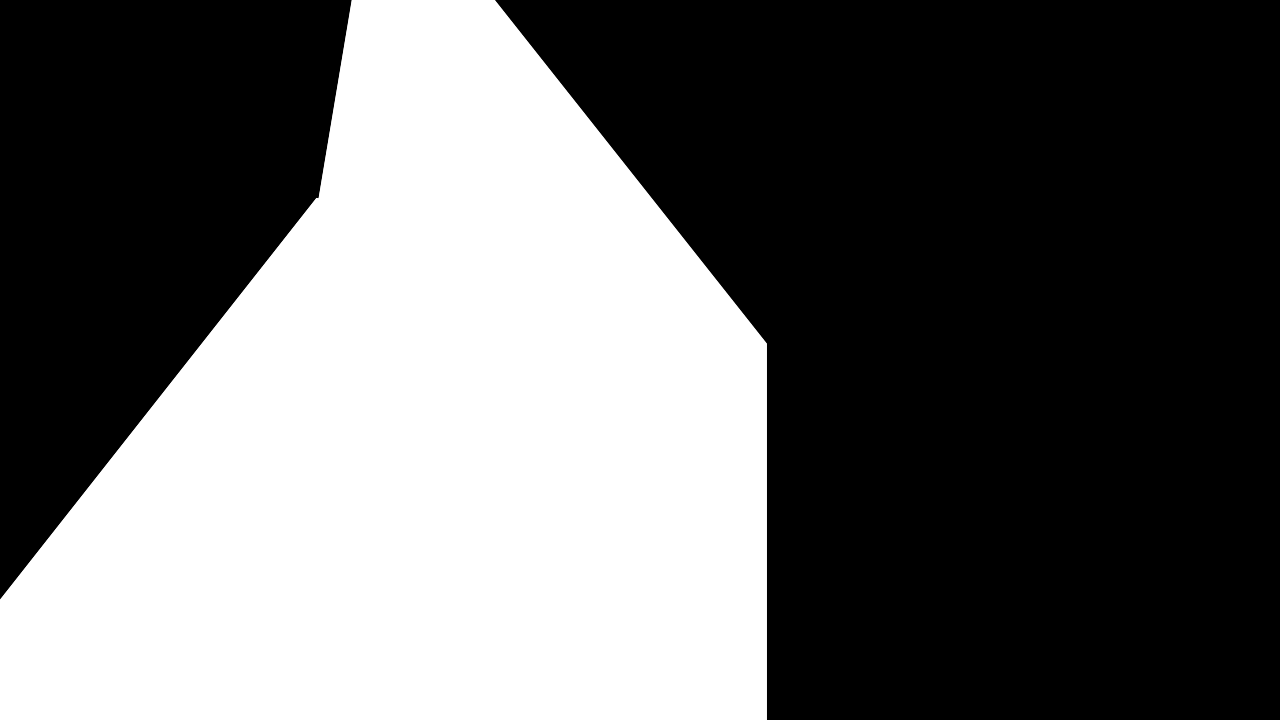

In [6]:
Image('Data/mask.png', width = 700)

**Contrasting bounding box of detected object including:**
1. Classified label & confidence level
2. Tracking ID
3. Dot for mid point of bounding box

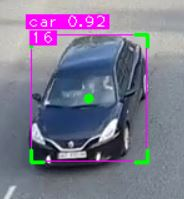

In [7]:
Image('Data/vehicle_bbox.jpg')

**Counting lines:**
1. Increases vehicle count when mid point of object passes through.
2. Individual lines separating specified lanes.
3. Flashes green on hit.

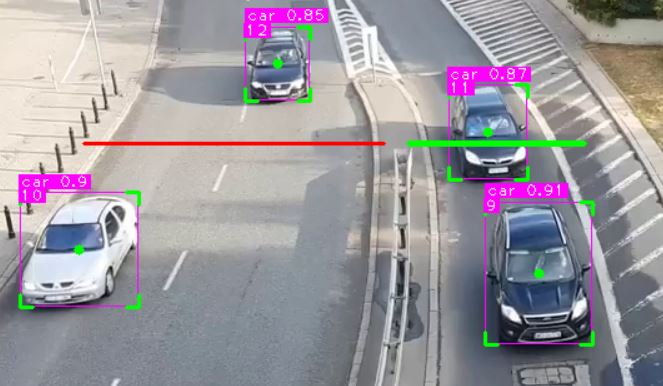

In [8]:
Image('Data/counting_lines.jpg')

**Vehicle count** for each lane specified:

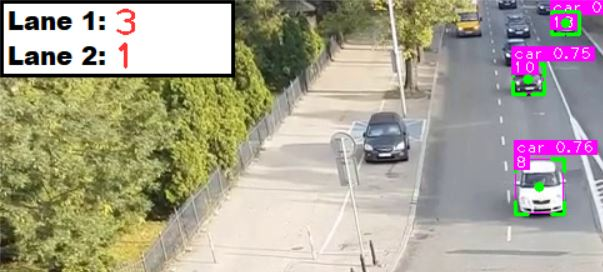

In [9]:
Image('Data/count_text.jpg')

## Final Result

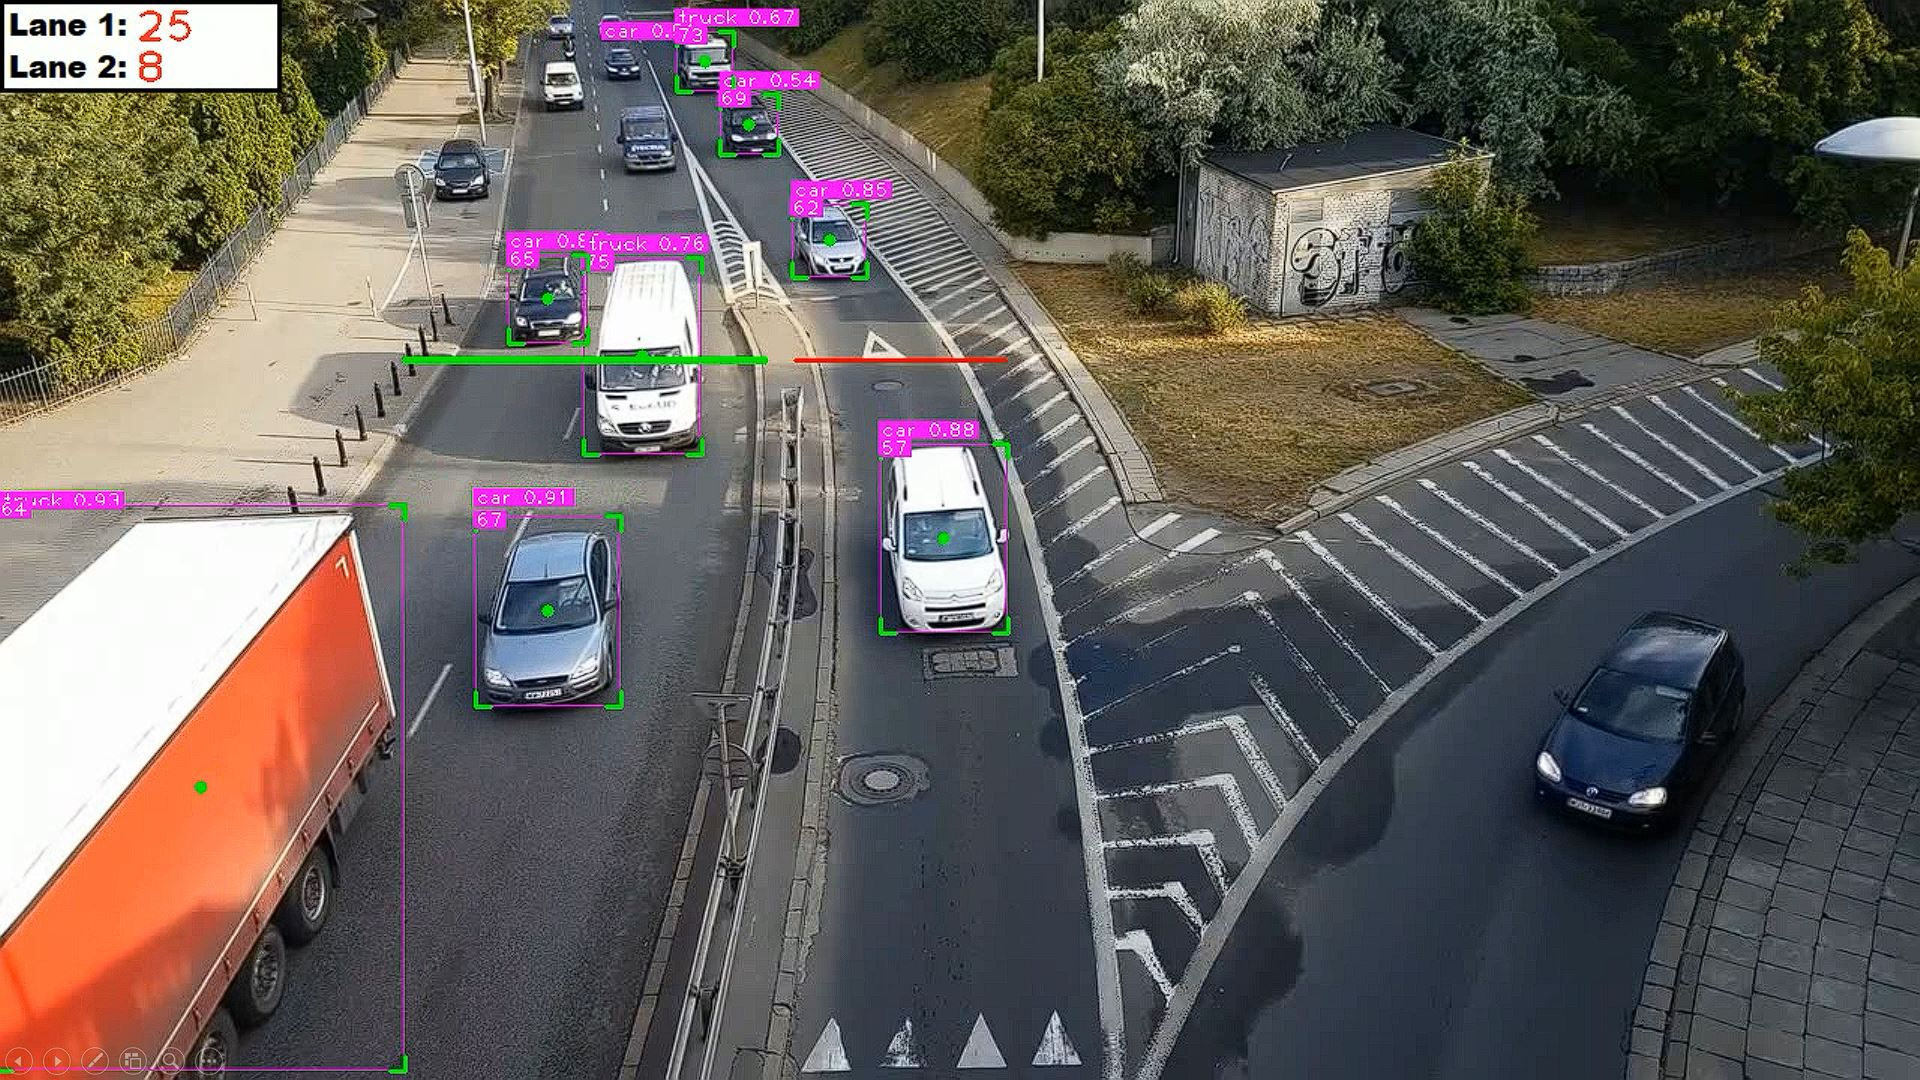

In [10]:
Image('Data/4K_road_traffic_turning_pred_showcase.jpg', width = 700)

Video for real time detection, tracking and counting included in data folder.